In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [3]:
# get the path of the model and set the frequency
model_folder = '/home/ubuntu/epilepsy_project/Models/'
model_name = 'full_montage_MGH_PSG_OG_no_flip'
path_model = os.path.join(model_folder,model_name)
path_prediction_continuous = '/home/ubuntu/epilepsy_project/Models/full_montage_MGH_PSG_OG_no_flip/Outputs/Bonobo/continuous'

In [4]:
# get prediction dataframe from Backstage/Model_name
bonobo_preds = pd.read_csv(path_model+'/bonobo_pred.csv')
# get labels dataframe from Judge
path_bonobo_labels = os.path.join('..','Tables','testset_bonobo_events.csv')
bonobo_labels = pd.read_csv(path_bonobo_labels)
# get list of control eegs 
path_controls = os.path.join('..','Tables','testset_controls.csv')
controls = pd.read_csv(path_controls)


In [55]:
# add predictions to the labels from the judge
bonobo_all = bonobo_labels.merge(bonobo_preds, on='event_file', how='left')

# only look at samples rated by > 8 people
ultra_quality_filter = bonobo_all['total_votes_received']>=8
# only look at samples rated rated strong agreement
frac_filter = (bonobo_all['fraction_of_yes'] > 6/8) | (bonobo_all['fraction_of_yes'] < 2/8)

# apply filters
bonobo_all = bonobo_all[ultra_quality_filter & frac_filter]

In [56]:
# extract labels and predictions as lists
labels = bonobo_all.fraction_of_yes.round(0).astype(int)
preds = bonobo_all.preds.values

In [57]:
# cacluate the true positive rate and threshold
_, tpr, thresholds = roc_curve(labels, preds)

from numpy import inf
# append 0 to thresholds and last value to tpr
thresholds = np.append(thresholds,0)
tpr = np.append(tpr,tpr[-1])

In [58]:
path_controls = os.path.join('/home/ubuntu/vergleicher','Tables','testset_controls.csv')
lut = pd.read_csv(path_controls)

In [59]:
# load prediction time series for all eeg files in the testset_controls fixed by the judge
preds_control = []
for eeg_file in controls.eeg_file:
    preds = np.load(path_prediction_continuous+'/'+eeg_file+'.npy')
    preds_control.append(preds)

REMOVE THE 100 BLCOKER!


In [60]:
results ={'threshold':[],'fp_ratios':[],'std_fp_ratios':[]}
for treshhold in tqdm(thresholds):
        ### Control evaluation
        # for each treshhold, count the number of control snippets that are above the treshhold (i.e. are predicted as spikes)
        fp_ratios = []
        for pred in preds_control:
                n_total_spikes = len(pred[pred>treshhold])
                fp_ratios.append(n_total_spikes/len(pred))
        results['threshold'].append(treshhold)
        results['fp_ratios'].append(np.mean(fp_ratios))        
        results['std_fp_ratios'].append(np.std(fp_ratios))
results = pd.DataFrame(results)

100%|██████████| 193/193 [00:00<00:00, 2896.44it/s]


In [61]:
# calculate ROC for modified AUC
roc_auc = auc(results.fp_ratios,tpr)

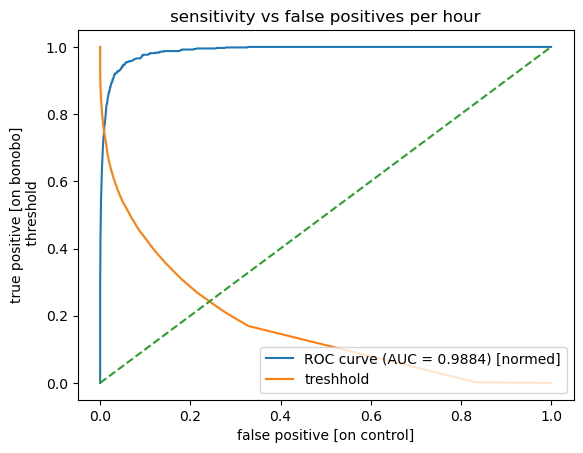

In [64]:
# plot modified AUC
thresholds[thresholds>1] = 1
plt.plot(np.array(results.fp_ratios),tpr,label='ROC curve (AUC = %0.4f) [normed]' % roc_auc)
plt.plot(np.array(results.fp_ratios),thresholds,label='treshhold')
plt.plot([0, max(results.fp_ratios)], [0, 1], linestyle='--')
plt.xlabel('false positive [on control]')
plt.legend(loc="lower right")
plt.ylabel('true positive [on bonobo]\n threshold')
plt.title('sensitivity vs false positives per hour')
plt.savefig(path_model+'/Results/modified_AUC.png')

In [66]:
# write brier score to text file
with open(path_model+'/Results/results.txt', 'a') as f:
    f.write('Modified AUC: '+str(roc_auc)+'\n')